In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import mbuild as mb
import parmed
import torch_geometric as tg
from torch_geometric.loader import DataLoader
import shutil
import rdkit 
import torch
from torch import nn, optim

import sys
sys.path.append("/raid6/homes/kierannp/projects/multi-egnn")
from megnn.datasets import *
from megnn.megnn import *
from megnn.utils import *

# try:
#     shutil.rmtree('./processed')
# except:
#     pass

/raid6/homes/kierannp/.conda/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from torchviz import make_dot
import torch_geometric as tg

dat = PdbBind_Dataset(root='.')
dtype = torch.float32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MEGNN(n_graphs=2, in_node_nf=dat.data.x_s.size(1), in_edge_nf=0, hidden_nf=32, device=device, n_layers=3, coords_weight=1.0,
             attention=True, node_attr=1)
model.load_state_dict(torch.load('models/model.pth', map_location=device))

dat = PdbBind_Dataset(root='.')
loader = DataLoader(dat, batch_size=1, follow_batch=['x_s', 'x_t', 'positions_s', 'positions_t'], shuffle=True)
for data in loader:
    dense_positions_s, atom_mask_s = tg.utils.to_dense_batch(data.positions_s, data.positions_s_batch)
    dense_positions_t, atom_mask_t = tg.utils.to_dense_batch(data.positions_t, data.positions_t_batch)
    batch_size_s, n_nodes_s, _ = dense_positions_s.size()
    batch_size_t, n_nodes_t, _ = dense_positions_t.size()
    atom_positions_s = dense_positions_s.view(batch_size_s * n_nodes_s, -1).to(device, dtype)
    atom_positions_t = dense_positions_t.view(batch_size_t * n_nodes_t, -1).to(device, dtype)
    edge_mask_s = atom_mask_s.unsqueeze(1) * atom_mask_s.unsqueeze(2)
    diag_mask = ~torch.eye(edge_mask_s.size(1), dtype=torch.bool).unsqueeze(0)
    edge_mask_s *= diag_mask
    edge_mask_s = edge_mask_s.view(batch_size_s * n_nodes_s * n_nodes_s, 1).to(device)
    edge_mask_t = atom_mask_t.unsqueeze(1) * atom_mask_t.unsqueeze(2)
    diag_mask = ~torch.eye(edge_mask_t.size(1), dtype=torch.bool).unsqueeze(0)
    edge_mask_t *= diag_mask
    edge_mask_t = edge_mask_t.view(batch_size_t * n_nodes_t * n_nodes_t, 1).to(device)
    atom_mask_s = atom_mask_s.view(batch_size_s * n_nodes_s, -1).to(device)
    atom_mask_t = atom_mask_t.view(batch_size_t * n_nodes_t, -1).to(device)
    one_hot_s, one_hot_s_mask = tg.utils.to_dense_batch(data.x_s, data.x_s_batch)
    one_hot_t, one_hot_s_mask = tg.utils.to_dense_batch(data.x_t, data.x_t_batch)
    one_hot_s = one_hot_s.view(batch_size_s * n_nodes_s, -1).to(device)
    one_hot_t = one_hot_t.view(batch_size_t * n_nodes_t, -1).to(device)
    edges_s = get_adj_matrix(n_nodes_s, batch_size_s, device)
    edges_t = get_adj_matrix(n_nodes_t, batch_size_t, device)
    label = data.y.to(device, dtype)
    pred = model(h0=[one_hot_s, one_hot_t], x=[atom_positions_s, atom_positions_t], all_edges=[edges_s, edges_t],
                all_edge_attr=[None, None], node_masks=[atom_mask_s, atom_mask_t],
                edge_masks=[edge_mask_s, edge_mask_t], n_nodes=[n_nodes_s, n_nodes_t])
    break
make_dot(pred.mean(), params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

/raid6/homes/kierannp/.conda/envs/ml/lib/python3.10/site-packages/torchviz/dot.py:65: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) < LooseVersion("1.9") and \
/raid6/homes/kierannp/.conda/envs/ml/lib/python3.10/site-packages/torchviz/dot.py:65: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) < LooseVersion("1.9") and \


'rnn_torchviz.png'

In [2]:
dat = PdbBind_Dataset(root='.')
dtype = torch.float32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MEGNN(n_graphs=2, in_node_nf=dat.data.x_s.size(1), in_edge_nf=0, hidden_nf=32, device=device, n_layers=3, coords_weight=1.0,
             attention=True, node_attr=1)
model.load_state_dict(torch.load('models/model.pth', map_location=device))

dat = PdbBind_Dataset(root='.')
loader = DataLoader(dat, batch_size=1, follow_batch=['x_s', 'x_t', 'positions_s', 'positions_t'], shuffle=True)

predictions = []
actuals = []
for data in loader:
    dense_positions_s, atom_mask_s = tg.utils.to_dense_batch(data.positions_s, data.positions_s_batch)
    dense_positions_t, atom_mask_t = tg.utils.to_dense_batch(data.positions_t, data.positions_t_batch)
    batch_size_s, n_nodes_s, _ = dense_positions_s.size()
    batch_size_t, n_nodes_t, _ = dense_positions_t.size()
    atom_positions_s = dense_positions_s.view(batch_size_s * n_nodes_s, -1).to(device, dtype)
    atom_positions_t = dense_positions_t.view(batch_size_t * n_nodes_t, -1).to(device, dtype)
    edge_mask_s = atom_mask_s.unsqueeze(1) * atom_mask_s.unsqueeze(2)
    diag_mask = ~torch.eye(edge_mask_s.size(1), dtype=torch.bool).unsqueeze(0)
    edge_mask_s *= diag_mask
    edge_mask_s = edge_mask_s.view(batch_size_s * n_nodes_s * n_nodes_s, 1).to(device)
    edge_mask_t = atom_mask_t.unsqueeze(1) * atom_mask_t.unsqueeze(2)
    diag_mask = ~torch.eye(edge_mask_t.size(1), dtype=torch.bool).unsqueeze(0)
    edge_mask_t *= diag_mask
    edge_mask_t = edge_mask_t.view(batch_size_t * n_nodes_t * n_nodes_t, 1).to(device)
    atom_mask_s = atom_mask_s.view(batch_size_s * n_nodes_s, -1).to(device)
    atom_mask_t = atom_mask_t.view(batch_size_t * n_nodes_t, -1).to(device)
    one_hot_s, one_hot_s_mask = tg.utils.to_dense_batch(data.x_s, data.x_s_batch)
    one_hot_t, one_hot_s_mask = tg.utils.to_dense_batch(data.x_t, data.x_t_batch)
    one_hot_s = one_hot_s.view(batch_size_s * n_nodes_s, -1).to(device)
    one_hot_t = one_hot_t.view(batch_size_t * n_nodes_t, -1).to(device)
    edges_s = get_adj_matrix(n_nodes_s, batch_size_s, device)
    edges_t = get_adj_matrix(n_nodes_t, batch_size_t, device)
    label = data.y.to(device, dtype)
    pred = model(h0=[one_hot_s, one_hot_t], x=[atom_positions_s, atom_positions_t], all_edges=[edges_s, edges_t],
                all_edge_attr=[None, None], node_masks=[atom_mask_s, atom_mask_t],
                edge_masks=[edge_mask_s, edge_mask_t], n_nodes=[n_nodes_s, n_nodes_t])
    predictions.append(pred.item())
    actuals.append(label.item())
    

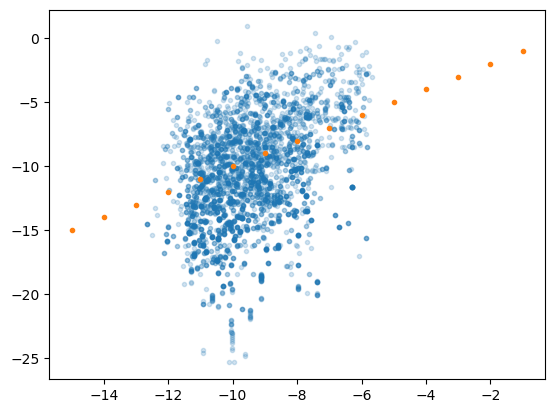

In [9]:
plt.plot(predictions, actuals, '.',alpha=.2)
plt.plot(np.arange(-15,0),np.arange(-15,0))

In [17]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

48519

In [15]:
device = torch.device("cpu")
dtype = torch.float32
df = pd.read_excel('./cloud_point.xlsx')
df = df.drop_duplicates().dropna()
dat = Cloud_Point_Dataset(root='.',dataframe=df)

batch_size = 16
loader = DataLoader(dat, batch_size=batch_size, follow_batch=['x_s', 'x_t', 'positions_s', 'positions_t'], shuffle=True)

model = MEGNN(n_graphs=2, in_node_nf=7, in_edge_nf=0, hidden_nf=64, device=device, n_layers=7, coords_weight=1.0,
             attention=True, node_attr=1, n_enviro=4)
model.load_state_dict(torch.load('model.pth'))
model = model.to(device)

In [9]:
model.eval()
preds = []
truths = []
for data in loader:  # Iterate in batches over the training dataset.
    dense_positions_s, atom_mask_s = tg.utils.to_dense_batch(data.positions_s, data.positions_s_batch)
    dense_positions_t, atom_mask_t = tg.utils.to_dense_batch(data.positions_t, data.positions_t_batch)
    batch_size_s, n_nodes_s, _ = dense_positions_s.size()
    batch_size_t, n_nodes_t, _ = dense_positions_t.size()
    atom_positions_s = dense_positions_s.view(batch_size_s * n_nodes_s, -1).to(device, dtype)
    atom_positions_t = dense_positions_t.view(batch_size_t * n_nodes_t, -1).to(device, dtype)
    edge_mask_s = atom_mask_s.unsqueeze(1) * atom_mask_s.unsqueeze(2)
    diag_mask = ~torch.eye(edge_mask_s.size(1), dtype=torch.bool).unsqueeze(0)
    edge_mask_s *= diag_mask
    edge_mask_s = edge_mask_s.view(batch_size_s * n_nodes_s * n_nodes_s, 1).to(device)
    edge_mask_t = atom_mask_t.unsqueeze(1) * atom_mask_t.unsqueeze(2)
    diag_mask = ~torch.eye(edge_mask_t.size(1), dtype=torch.bool).unsqueeze(0)
    edge_mask_t *= diag_mask
    edge_mask_t = edge_mask_t.view(batch_size_t * n_nodes_t * n_nodes_t, 1).to(device)
    atom_mask_s = atom_mask_s.view(batch_size_s * n_nodes_s, -1).to(device)
    atom_mask_t = atom_mask_t.view(batch_size_t * n_nodes_t, -1).to(device)
    one_hot_s, one_hot_s_mask = tg.utils.to_dense_batch(data.x_s, data.x_s_batch)
    one_hot_t, one_hot_s_mask = tg.utils.to_dense_batch(data.x_t, data.x_t_batch)
    one_hot_s = one_hot_s.view(batch_size_s * n_nodes_s, -1).to(device)
    one_hot_t = one_hot_t.view(batch_size_t * n_nodes_t, -1).to(device)
    edges_s = get_adj_matrix(n_nodes_s, batch_size_s, device)
    edges_t = get_adj_matrix(n_nodes_t, batch_size_t, device)
    enviro = data.enviro.to(device, dtype)
    label = data.y.to(device, dtype)
    
    pred = model(h0=[one_hot_s, one_hot_t], x=[atom_positions_s, atom_positions_t], all_edges=[edges_s, edges_t],
                        all_edge_attr=[None, None], node_masks=[atom_mask_s, atom_mask_t],
                        edge_masks=[edge_mask_s, edge_mask_t], n_nodes=[n_nodes_s, n_nodes_t], enviro = enviro)
    preds.extend(list(pred.detach()))
    truths.extend(list(label))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x4 and 7x64)

Text(0, 0.5, 'Predicted')

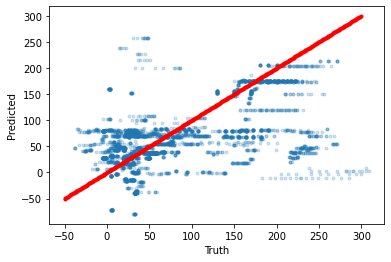

In [24]:
plt.plot(truths, preds,'.',alpha=.2)
plt.plot(list(range(-50,300)), list(range(-50,300)), 'r.')
plt.xlabel('Truth')
plt.ylabel('Predicted')

In [ ]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor

# create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
df = pd.read_excel('./cloud_point.xlsx')
df = df.drop_duplicates().dropna()
# fit the regressor with x and y data
regressor.fit(df[''], y)
